Домашнее задание
Задача с конечным набором дискретных действий

Цель:
В процессе выполнения задания вы проведёте первичный анализ поставленной задачи и выберете подходящий алгоритм.
Для успешного выполнения задания вам потребуется:

понимание отличий между средами с дискретными и непрерывным набором действий;
навык оценки задачи и выбора подходящего алгоритма;
навык разработки несложных алгоритмов на Python;
навык реализации нейронных сетей с использованием фреймворка PyTorch;
навык отладки алгоритма и выбора оптимальных гиперпараметров.

Описание/Пошаговая инструкция выполнения домашнего задания:
Пошаговая инструкция:


реализуйте алгоритм DQN с реплей буффером и мягким обновлением целевой сети;
обучите агента в среде Lunar Lander;
представьте исходный код, обученного агента и график средней награды за эпизод и средней наградой за 100 эпизодов по мере обучения агента.

In [99]:
import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import namedtuple, deque
import random
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
gym.__version__

'0.29.1'

In [101]:
torch.__version__
torch.manual_seed(164)

In [102]:
torch.cuda.is_available()

True

In [103]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [104]:
class DQN(nn.Module):
    def __init__(self, observations_count, actions_count):
        super(DQN, self).__init__()

        l1 = 256
        l2 = 256

        self.layer1 = nn.Linear(observations_count, l1)
        self.layer2 = nn.Linear(l1, l2)
        self.layer3 = nn.Linear(l2, actions_count)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [105]:
class Agent:
    def __init__(self):
        self.steps_done = 0
        self.epsilon = 1
        self.epsilon_min = 0.05
        self.epsilon_decay = 1000
        self.gamma = 0.99
        self.tau = 0.005
        self.lr = 0.005
        self.full_memory_length = 10000

    def model(self, observations_count: int, actions_count: int):
        return DQN(observations_count, actions_count).to(device)

    def select_action(self, state):
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        self.steps_done += 1

        # если случайный порог больше epsilon-порога
        if random.uniform(0, 1) < self.epsilon:
            with torch.no_grad():
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [106]:
agent = Agent()
env = gym.make("LunarLander-v2")

state, info = env.reset()

n_actions = env.action_space.n
n_observations = len(state)

policy_net = agent.model(n_observations, n_actions).to(device)
target_net = agent.model(n_observations, n_actions).to(device)
best_net = agent.model(n_observations, n_actions).to(device)

optimizer = optim.AdamW(policy_net.parameters(), lr=agent.lr, amsgrad=True)
memory = ReplayMemory(agent.full_memory_length)
episode_durations = []

In [107]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return

    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * agent.gamma) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

In [108]:
num_episodes = 1500 if torch.cuda.is_available() else 500

total_reward = []
max_eposide_reward = 0

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    state, info = env.reset() # environment reset
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count(): # iterate until 'done'
        action = agent.select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # присваиваем следующее состояние
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # push into memory
        memory.push(state, action, next_state, torch.tensor([reward], device=device))

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * agent.tau + target_net_state_dict[key]  * (1 - agent.tau)
        target_net.load_state_dict(target_net_state_dict)

        # Если получили terminated or truncated завершаем эпизод обучения
        if terminated or truncated:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

    # save best net
    if max_eposide_reward < episode_reward:
        max_eposide_reward = episode_reward
        best_net.load_state_dict(policy_net.state_dict())

print('Complete')

100%|██████████| 1500/1500 [45:39<00:00,  1.83s/it]

Complete


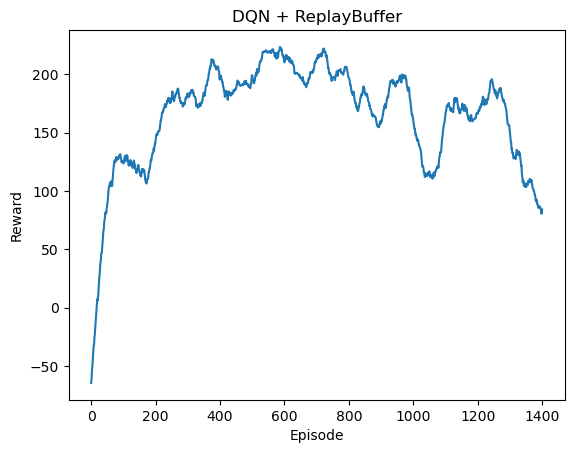

In [109]:
# show mean performance
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size) / window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [111]:
# show performance of the best model
env_human = gym.make("LunarLander-v2", render_mode='human', max_episode_steps = 400)

for i_episode in range(10):
    observation, info = env_human.reset()

    while True:
        observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        action_human = best_net(observation).max(1)[1].view(1, 1)
        observation, reward, terminated, truncated, _ = env_human.step(action_human.item())
        episode_reward += reward

        if terminated or truncated:
            break

    print(f'episode reward: {reward}')

env_human.close()
print('End.')

episode reward: -1.4975140303680579
episode reward: -0.5516873387226464
episode reward: -100
episode reward: 100
episode reward: 2.200977882941186
episode reward: -0.29026118150436203
episode reward: -100
episode reward: -0.7515072383139689
episode reward: -100
episode reward: 100
End.
